<a href="https://colab.research.google.com/github/dlkt101101/STAT441-Project/blob/main/VGG16_Darren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 441: Statistical Learning - Classification
## Classifying Astrophysical Images
Prepared by:\
Darren Alexander Lam Kin Teng

In [ ]:
!pip install --upgrade tf-keras
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.19.0
    Uninstalling tf_keras-2.19.0:
      Successfully uninstalled tf_keras-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tenso

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
import keras
import os
import shutil

In [ ]:
from google.colab import drive
from itertools import product
# Keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, RandomFlip, RandomRotation, \
RandomZoom, RandomShear, Normalization, Dropout, Flatten, Lambda
from keras.activations import relu, sigmoid, softmax
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications import VGG16, ResNet50
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

## Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive'

In [ ]:
training_path = path+'/astro_dataset_maxia/astro_dataset_maxia/training'
test_path = path+'/astro_dataset_maxia/astro_dataset_maxia/test'
validation_path = path+'/astro_dataset_maxia/astro_dataset_maxia/validation'

Creating training, validation and testing batches for images.

In [ ]:
BATCH_SIZE =32
IMAGE_SIZE =(224, 224)
SEED = 123

In [ ]:
training_batch = tf.keras.utils.image_dataset_from_directory(
    directory=training_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    follow_links=('.jpg', '.jpeg', '.png'),
    seed=SEED)
class_names = training_batch.class_names
training_batch = training_batch.prefetch(tf.data.AUTOTUNE)

validation_batch = tf.keras.utils.image_dataset_from_directory(
    directory=validation_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    follow_links=('.jpg', '.jpeg', '.png'),
    seed=SEED).prefetch(tf.data.AUTOTUNE)

test_batch = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    follow_links=('.jpg', '.jpeg', '.png'),
    seed=SEED).prefetch(tf.data.AUTOTUNE)

Found 2416 files belonging to 12 classes.
Found 658 files belonging to 12 classes.
Found 345 files belonging to 12 classes.


Visualizing the Images

In [ ]:
iterator = iter(training_batch)
img = next(iterator)
img = img[0][0].numpy().astype(np.int32)

# let's visualize an image
plt.imshow(img)

Implementing image preprocessing by:
1. Resizing the image (completed and resized to (256,256) )
2. Normalizing the pixel values
3. Data Augmentations\
  3.1. Normalization of pixel values\
  3.2. Random Rotations\
  3.3. Random Shear\
  3.4. Random Zoom\
  3.5. Random Flip

## Model Implementaion

### VGG16 Neural Network Implementaion

In [ ]:
INPUT_SHAPE = IMAGE_SIZE+(3,)
mVGG16 = VGG16(include_top= False,
              input_shape=INPUT_SHAPE,
              weights='imagenet',
              name = "vgg16")

# we will avoid training on previous layers
for layer in mVGG16.layers:
  layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mVGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

##### VGG16 Parameter Tuning
To improve our model's accuracy, we will perform hyperparameter tuning. However, due to limited computational resources, we will only tune on 3 hyperparameters.
* Number of epochs
* Learning rate
* Weight decay

In [ ]:
class CheckpointSaver(ModelCheckpoint):
  def __init__(self, filepath, epochs_to_save):
      super().__init__(filepath, save_freq='epoch', save_best_only=False, verbose=0)
      self.epochs_to_save = epochs_to_save

  def on_epoch_end(self, epoch, logs=None):
      # epoch is 0-indexed, so we check for (epoch + 1)
      if (epoch + 1) in self.epochs_to_save:
          print(f"  [Checkpoint] Saving model at epoch {epoch + 1}")
          super().on_epoch_end(epoch, logs)


In [ ]:
NUM_CLASSES = len(class_names)
epochs = [4,8,12]
MAX_EPOCH = max(epochs)
weight_decays = [0.0, 0.001, 0.0001]
learning_rates = [0.0001, 0.001, 0.01]

# create a dataframe to store the weight decays, learning rate and epochs
parameter_grid = list(product(weight_decays, learning_rates))

In [ ]:
def create_compile_model_VGG16(wd, lr, num_classes=NUM_CLASSES):
  model = Sequential([
      RandomRotation(0.5),
      RandomShear(x_factor=0.9, y_factor=0.9),
      RandomZoom(0.2),
      RandomFlip(mode="horizontal_and_vertical"),
      Lambda(vgg16_preprocess_input),
      mVGG16,
      Flatten(),
      Dropout(0.5),
      Dense(256, activation='relu', kernel_regularizer = l2(wd)),
      Dense(len(class_names), activation='softmax', kernel_regularizer = l2(wd))
  ])

  model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer = Adam(learning_rate=lr),
                metrics = ['accuracy'])

  return model


Iterating over the parameter grid

In [ ]:
GDRIVE_MODEL_PATH = '/content/MyDrive/Best_Model'
CHECKPOINT_MODEL_PATH = '/content/MyDrive/Checkpoint_Models'
FINAL_BEST_MODEL_NAME = 'Absolute_Best_Model.keras'

In [ ]:
all_results = []

print(f"\nStarting {len(parameter_grid)} training runs...")

for i, (wd, lr) in enumerate(parameter_grid):
    run_name = f"run_{i+1}_wd{wd:.4f}_lr{lr:.4f}"
    print(f"--- Run {i+1}/{len(parameter_grid)}: WD={wd}, LR={lr} ---")
    model = create_compile_model_VGG16(wd, lr)

    # Template path to save the 3 checkpoints for this run
    filepath_template = os.path.join(CHECKPOINT_MODEL_PATH, run_name + "_epoch_{epoch:02d}.keras")

    checkpoint_saver = CheckpointSaver(
        filepath=filepath_template,
        epochs_to_save=epochs)

    historyFit = model.fit(
        x=training_batch,
        validation_data=validation_batch,
        epochs=MAX_EPOCH,
        verbose=1,
        callbacks=[checkpoint_saver])

    history_df = pd.DataFrame(historyFit.history)
    history_df['epoch'] = history_df.index + 1

    # Filter for only epochs 4, 8 and 12
    checkpoint_df = history_df[history_df['epoch'].isin(epochs)].copy()

    checkpoint_df['weight_decay'] = wd
    checkpoint_df['learning_rate'] = lr

    # Store the file path for the saved checkpoint model
    checkpoint_df['model_path'] = checkpoint_df['epoch'].apply(
        lambda e: os.path.join(CHECKPOINT_MODEL_PATH, run_name + f"_epoch_{e:02d}.keras")
    )

    all_results.append(checkpoint_df)

final_results_df = pd.concat(all_results, ignore_index=True)


Starting 9 training runs...
--- Run 1/9: WD=0.0, LR=0.0001 ---
Epoch 1/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 542s 7s/step - accuracy: 0.3218 - loss: 9.1810 - val_accuracy: 0.8526 - val_loss: 0.6758
Epoch 2/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 417ms/step - accuracy: 0.6868 - loss: 2.4922 - val_accuracy: 0.9012 - val_loss: 0.4364
Epoch 3/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - accuracy: 0.7820 - loss: 1.4569 - val_accuracy: 0.9468 - val_loss: 0.3180
Epoch 4/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7930 - loss: 1.4816  [Checkpoint] Saving model at epoch 4
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 416ms/step - accuracy: 0.7930 - loss: 1.4811 - val_accuracy: 0.9407 - val_loss: 0.2639
Epoch 5/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 36s 475ms/step - accuracy: 0.8319 - loss: 0.9964 - val_accuracy: 0.9514 - val_loss: 0.2357
Epoch 6/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 423ms/step - accuracy: 0.8332 - loss: 0.9749 - val_accuracy: 0.9605 - val_loss: 0.1899
Epoch 7/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 413ms/ste

Displaying the results of all our parameters

In [ ]:
final_results_df

,accuracy,loss,val_accuracy,val_loss,epoch,weight_decay,learning_rate,model_path
0,0.790149,1.445116,0.940729,0.263915,4,0.0000,0.0001,/content/MyDrive/Checkpoint_Models/run_1_wd0.0...
1,0.850993,0.759981,0.960486,0.170910,8,0.0000,0.0001,/content/MyDrive/Checkpoint_Models/run_1_wd0.0...
2,0.884934,0.542604,0.972644,0.140224,12,0.0000,0.0001,/content/MyDrive/Checkpoint_Models/run_1_wd0.0...
3,0.849752,0.648432,0.933131,0.267945,4,0.0000,0.0010,/content/MyDrive/Checkpoint_Models/run_2_wd0.0...
4,0.865066,0.546282,0.952888,0.227867,8,0.0000,0.0010,/content/MyDrive/Checkpoint_Models/run_2_wd0.0...
5,0.886589,0.412453,0.925532,0.255526,12,0.0000,0.0010,/content/MyDrive/Checkpoint_Models/run_2_wd0.0...
6,0.600166,1.571234,0.738602,0.837307,4,0.0000,0.0100,/content/MyDrive/Checkpoint_Models/run_3_wd0.0...
7,0.669702,1.316962,0.843465,0.618233,8,0.0000,0.0100,/content/MyDrive/Checkpoint_Models/run_3_wd0.0...
8,0.600993,1.520231,0.762918,1.885861,12,0.0000,0.0100,/content/MyDrive/Checkpoint_Models/run_3_wd0.0...
9,0.794288,1.823439,0.939210,0.736177,4,0.0010,0.0001,/content/MyDrive/Checkpoint_Models/run_4_wd0.0...


We will take the parameters that provided the best validation accuracy

In [ ]:
best_result = final_results_df[final_results_df['val_accuracy'] == final_results_df['val_accuracy'].max()]
best_epoch = best_result['epoch'].item()
best_weight_decay = best_result['weight_decay'].item()
best_learning_rate = best_result['learning_rate'].item()

best_result

,accuracy,loss,val_accuracy,val_loss,epoch,weight_decay,learning_rate,model_path
2,0.884934,0.542604,0.972644,0.140224,12,0.0,0.0001,/content/MyDrive/Checkpoint_Models/run_1_wd0.0...


In [ ]:
# bestVGG16Path = os.path.join(GDRIVE_MODEL_PATH, FINAL_BEST_MODEL_NAME)
# bestVGG16 = tf.keras.models.load_model(bestVGG16Path)

In [ ]:
bestVGG16 = create_compile_model_VGG16(best_weight_decay, best_learning_rate, num_classes=NUM_CLASSES)

# fitting the best model
bestVGG16model = bestVGG16.fit(x=training_batch, validation_data=validation_batch, epochs=best_epoch, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 414ms/step - accuracy: 0.3212 - loss: 9.3538 - val_accuracy: 0.8359 - val_loss: 0.9920
Epoch 2/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 488ms/step - accuracy: 0.6748 - loss: 2.4685 - val_accuracy: 0.8906 - val_loss: 0.6266
Epoch 3/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 424ms/step - accuracy: 0.7741 - loss: 1.4927 - val_accuracy: 0.8997 - val_loss: 0.5763
Epoch 4/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 36s 472ms/step - accuracy: 0.8151 - loss: 1.1234 - val_accuracy: 0.9438 - val_loss: 0.2839
Epoch 5/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 412ms/step - accuracy: 0.8301 - loss: 1.0169 - val_accuracy: 0.9377 - val_loss: 0.2790
Epoch 6/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 413ms/step - accuracy: 0.8138 - loss: 1.0819 - val_accuracy: 0.9088 - val_loss: 0.4388
Epoch 7/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 413ms/step - accuracy: 0.8433 - loss: 0.7560 - val_accuracy: 0.9529 - val_loss: 0.2164
Epoch 8/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step - accuracy: 0.8691 - loss: 0.6905 - val_accu

##### VGG16 Predictions

In [ ]:
predictionsVGG16 = bestVGG16.predict(x=test_batch, verbose=1)
predictionsVGG16Class = np.argmax(predictionsVGG16, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step


##### VGG16 Metrics

In [ ]:
all_images = []
all_true_labels = []

for images, labels in test_batch.unbatch():
    all_images.append(images.numpy())
    all_true_labels.append(labels.numpy())

all_images = np.array(all_images)
all_true_labels = np.array(all_true_labels)

In [ ]:
# accuracy of predictions
accuracyVGG16 = np.mean(all_true_labels == predictionsVGG16Class)
print("VGG16's prediction accuracy: {}%".format(round(accuracyVGG16 * 100,2)))

VGG16's prediction accuracy: 94.78%


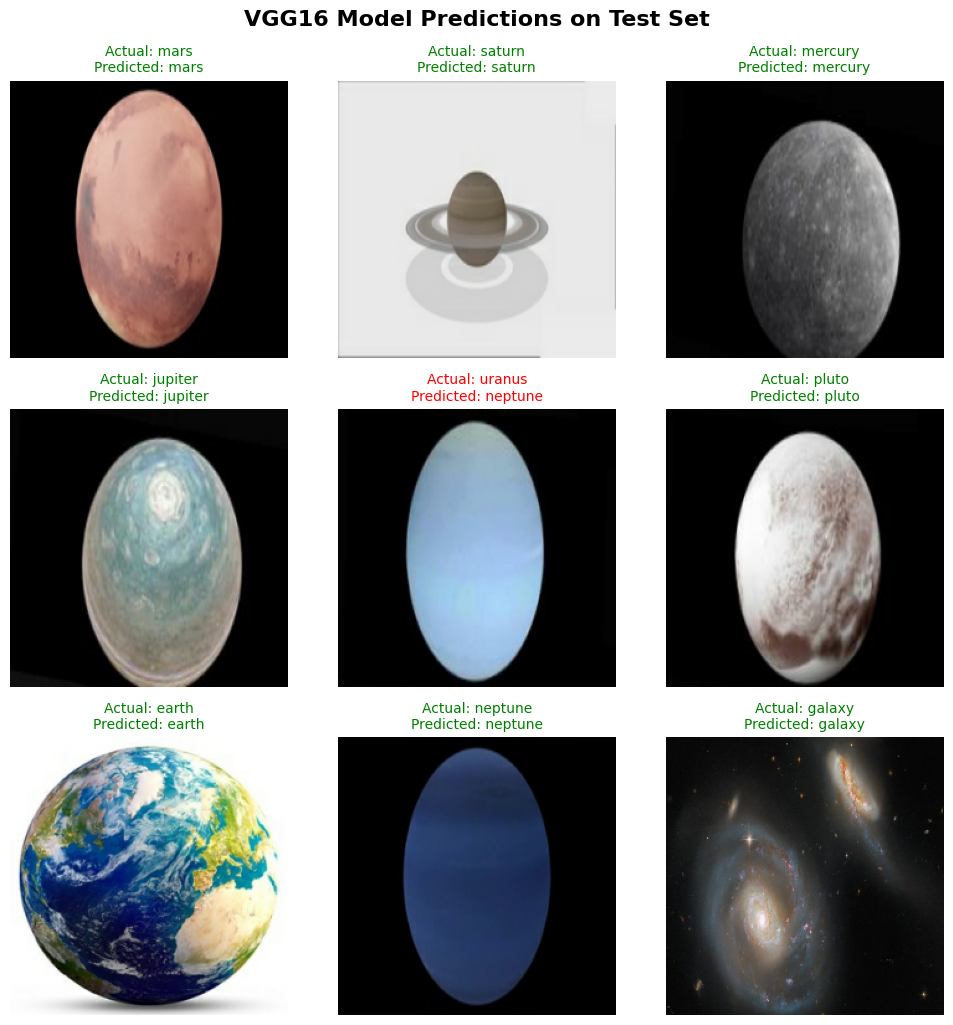

In [ ]:
SAMPLE_SIZE = 9

sample_indices = np.random.choice(len(all_images), size=SAMPLE_SIZE, replace=False)
sample_images = all_images[sample_indices]
sample_true_labels = all_true_labels[sample_indices]
sample_predictions = predictionsVGG16Class[sample_indices]

# plotting 3x3 subplot of predictions
fig, axs = plt.subplots(3,3, figsize=(10,10))
axes = axs.flatten()

for i in range(SAMPLE_SIZE):
  ax = axes[i]
  image = sample_images[i]
  image_to_plot = np.clip(image, 0, 255).astype(np.uint8)
  true_label = sample_true_labels[i]
  predicted_label = sample_predictions[i]

  isCorrect = (predicted_label == true_label)
  color = 'green' if isCorrect else 'red'

  ax.imshow(image_to_plot)
  ax.set_title(
      f"Actual: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}",
      color=color,
      fontsize=10
  )
  ax.axis('off')

for j in range(SAMPLE_SIZE, 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('VGG16 Model Predictions on Test Set', y=1.02, fontsize=16, fontweight='bold')
plt.show()